In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import folium # map rendering library
from folium.features import DivIcon #used to add popup info to a map
!pip install pyshp
import shapely
from shapely.geometry import Point, Polygon
import shapefile
import sklearn
from sklearn.cluster import KMeans

## JNB Lab

### Introduction
In Fall  2021, the Housing Equity Initative (HEI) was launched by Sunshine Gospel Ministries in partnership with The BLOCK Movement, both non-profit organizations deeply rooted in  the South Side of Chicago.
Housing inequity between White and Black people living in the United States is a nationwide problem. In 2020 the National Association of Realtors indicated over 70% of Whites live in their own homes, while for Blacks it is less than 45%. Based on Federal Reserve data for 2019, the real estate wealth per capita for Whites is over 140,000, but for Blacks, it is under $60,000.

In the aftermath of the Great Migration of those escaping the Jim Crow South, which brought a large influx of Blacks into Chicago in the first half of the 20th century, decades of housing-related injustices including redlining, blockbusting, restrictive covenants, and slum land-lording have occurred on the South and West sides [Amdat 2021]. Many communities affected by structural racism are carrying the burden of inequitable housing. For example, for the Woodlawn community area with roughly 9,000 housing units, almost 80% 80% are renter-occupied, 36% of which in 2014 were using more than 50% of their income on rent. (For Woodlawn, the 2014 area median income (AMI) was roughly $25,000.)

HEI is focused on affordable home ownership in the Woodlawn area, the active construction site of the $500+ million dollar Obama Presidential Center.  HEI seeks to overcome a long history of structural barriers to home ownership  by providing three forms of support for vulnerable families:

Tax-Sale Benevolence Program (TSBP) to help existing homeowners avoid foreclosure due to tax sales;

Downpayment Assistance Program (DAP) to assist responsible families with down payment on a home purchase; and

Affordable Revitalization Program (ARP) to revitalize empty lots and rehab properties with well-constructed, owner-occupied homes.


HEI's goal is not simply to increase home ownership for neighborhood residents who have experienced housing inequity, but to maximize positive, rather than negative, home ownership experiences

### Park district facilities in Ward 20

There are several factors which can make a difference in whether a young person growing up in a disadvantaged urban community will flourish. One type of community asset are park district facilities.  Here we will create a map of such resources for HEI's neighborhood.

1) Import Ward 20 map.

In [2]:
img = Image.open("ward20.png")

2) Define a function to convert (lat,lon) to an (x,y) location on the Ward 20 map.

In [3]:
#Function to convert (lat,lon) to (x,y) location on the Ward 20 map
def coord(lat,lon):
    minlon=-87.672079
    maxlon=-87.586493
    xmin=47
    xmax=806
    x=xmin+(lon-minlon)*(xmax-xmin)/(maxlon-minlon)
    minlat=41.778798
    maxlat=41.801243
    ymax=189
    ymin=389
    y=ymin+(lat-minlat)*(ymax-ymin)/(maxlat-minlat)
    return x,y

3) Import a shape file with the Ward 20 boundary.

In [4]:
sf = shapefile.Reader("ward20.shp")
shapes=sf.shapes()

4) Read in the Chicago Park District data from the Chicago Data Portal.

In [5]:
parks=pd.read_json("https://data.cityofchicago.org/resource/eix4-gf83.json?$limit=400000")

In [6]:
parks.head(1)

,the_geom,objectid_1,park,park_no,facility_n,facility_t,x_coord,y_coord,gisobjid
0,"{'type': 'Point', 'coordinates': [-87.63769762...",1,HAMILTON (ALEXANDER),9,CULTURAL CENTER,SPECIAL,-87.637698,41.762999,2494


In [7]:
p=parks[["facility_n","facility_t","x_coord","y_coord"]]
p.columns=["type","loc","longitude","latitude"]
p.head(3)

,type,loc,longitude,latitude
0,CULTURAL CENTER,SPECIAL,-87.637698,41.762999
1,GYMNASIUM,INDOOR,-87.637929,41.762817
2,BASEBALL JR/SOFTBALL,OUTDOOR,-87.636914,41.760849


In [8]:
p["type"].value_counts()

BASKETBALL BACKBOARD         771
BASEBALL JR/SOFTBALL         537
PLAYGROUND                   517
TENNIS COURT                 507
BASKETBALL COURT             323
                            ... 
GOLF COURSE MINIATURE          1
SPORT ROLLER COIRT             1
NATURE PLAY AREA               1
ALFRED CALDWELL LILY POND      1
ART TURF - REGULATION          1
Name: type, Length: 75, dtype: int64

5) Map the Park District data.

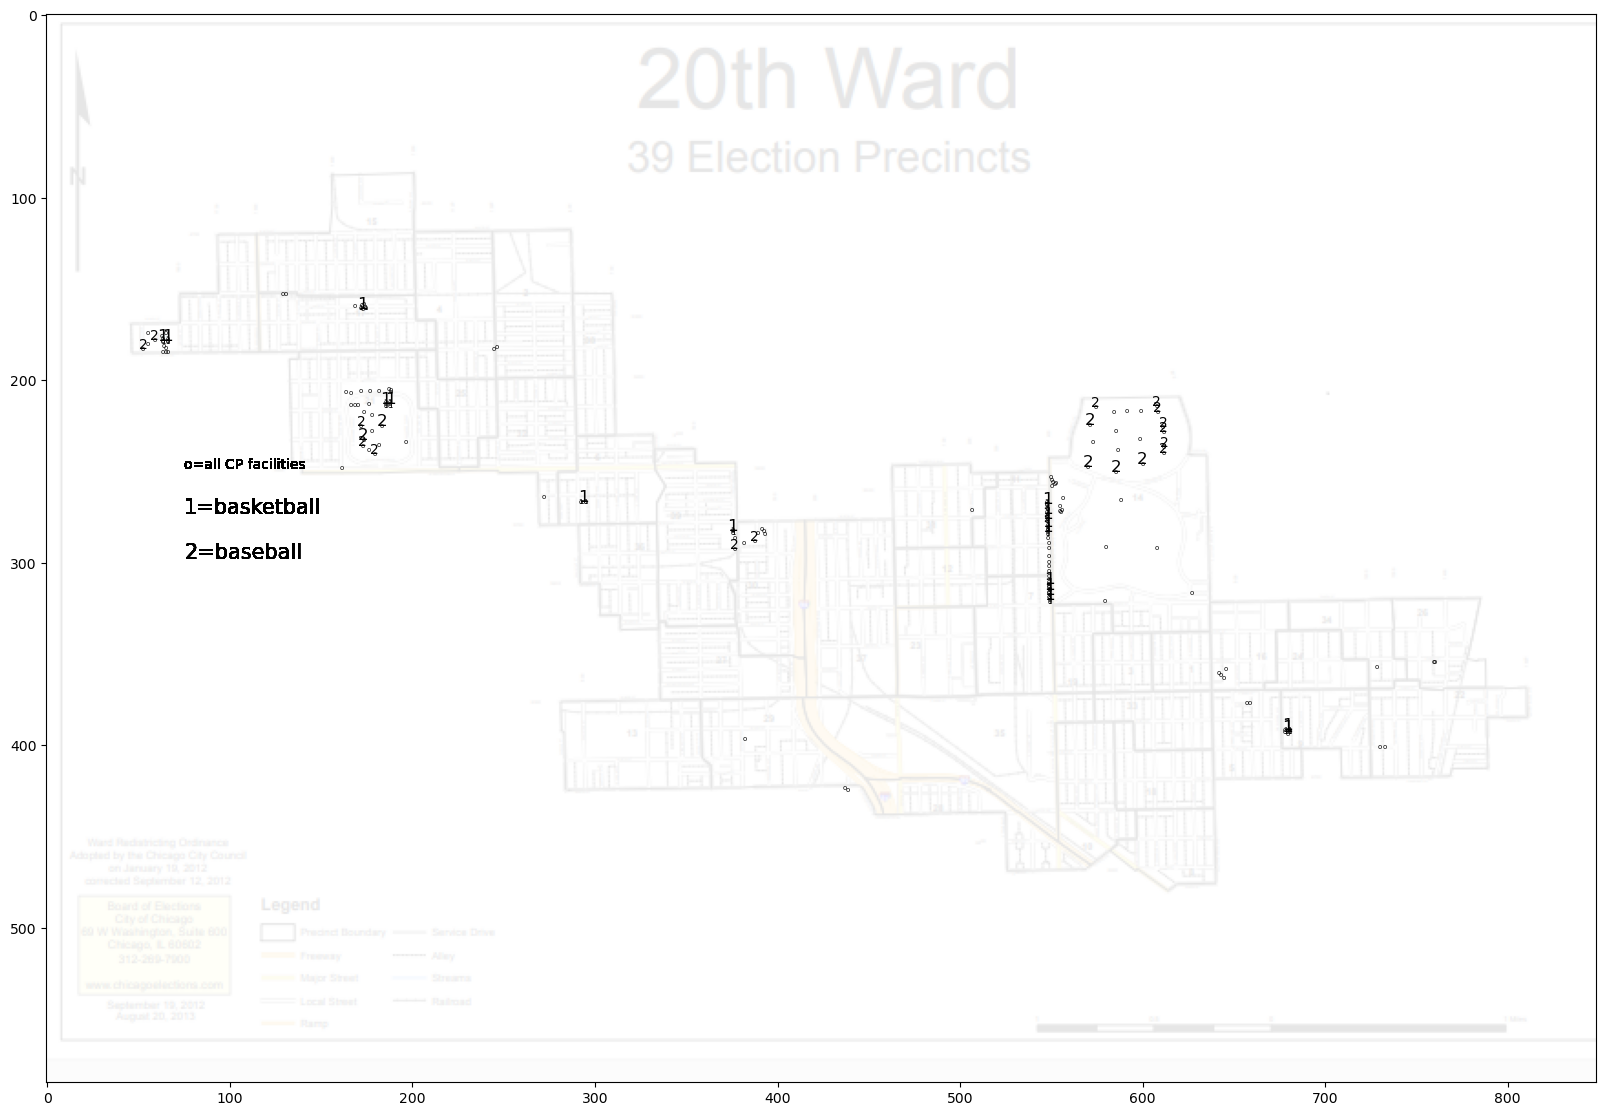

In [9]:
import matplotlib.pyplot as plt
from PIL import Image
img = Image.open("ward20.png")
plt.figure(figsize=(20,16))
plt.imshow(img,alpha=.1)
df=p

#use this format
for i in df.index:
    [x,y]=coord(df.loc[i,"latitude"],df.loc[i,"longitude"])
    point=Point(df.loc[i,"longitude"],df.loc[i,"latitude"])
    if point.within(Polygon(shapes[3].points)):
        plt.text(x,y,"o",color='black',size=5,ha='center',va='bottom')
        plt.text(75,250,"o=all CP facilities",color='black',size=10,ha='left',va='bottom')
        if df.loc[i,"type"]=="BASKETBALL BACKBOARD":
            plt.text(x,y,"1",color='black',size=5,ha='center',va='bottom')
            plt.text(75,275,"1=basketball",color='black',size=15,ha='left',va='bottom')
        if df.loc[i,"type"]=="BASKETBALL COURT":
            plt.text(x,y,"1",color='black',size=12,ha='center',va='bottom')
        if df.loc[i,"type"]=="BASEBALL JR/SOFTBALL":
            plt.text(x,y,"2",color='black',size=10,ha='center',va='bottom')
            plt.text(75,300,"2=baseball",color='black',size=15,ha='left',va='bottom')
        if df.loc[i,"type"]=="BASEBALL SR":
            plt.text(x,y,"2",color='black',size=12,ha='center',va='bottom')
plt.savefig("recreation.png")
plt.show()

```{admonition} Problem 1
Add playgrounds to the map in red.
```

### Tax Year 2019 Owner-Occupied Tax Sale Data for Ward 20</h3>

1) Import tax-sale data.

In [10]:
df=pd.read_excel("Ward20residentialparcels.xlsx")
df2=pd.read_excel("HEIcandidateparcels.xlsx")

2) Create map of Ward 20 residential parcels and HEI candidate parcels.

In [11]:
Chicago_map = folium.Map(location=[41.78453, -87.62859],   zoom_start=13,alpha=.1)
for i in np.arange(0,169,1):
    p=[df.loc[i,"latitude"],df.loc[i,"longitude"]]
    folium.Marker(p,icon=DivIcon(
        icon_size=(100,0),
        icon_anchor=(0,8),
        html='<div style="font-size: 2pt; color : lightgray">'+'</div>',
            )).add_to(Chicago_map)
    Chicago_map.add_child(folium.CircleMarker(p, radius=1,color='lightgray'))
for i in np.arange(0,92,1):
    p2=[df2.loc[i,"latitude"],df2.loc[i,"longitude"]]
    folium.Marker(p2,icon=DivIcon(
        icon_size=(100,0),
        icon_anchor=(0,8),
        html='<div style="font-size: 6pt; color : black">'+'   '+str(df2.loc[i,"Total Tax Due"])+ '</div>',
            )).add_to(Chicago_map)
    Chicago_map.add_child(folium.CircleMarker(p2, radius=1,color='black'))
Chicago_map.save("HEItaxsaleyear19maprev.html")
Chicago_map

```{admonition} Exercise
Make a histogram showing tax sale amouts for Ward 20 residential parcels and HEI candidate parcels.
```

### Low Income Tract Clustering

1) Read in census tract data.

In [12]:
rawdf=pd.read_csv("tract_covariates.csv")

In [13]:
rawdf.columns

Index(['tract', 'county', 'state', 'hhinc_mean2000', 'mean_commutetime2000',
       'frac_coll_plus2010', 'frac_coll_plus2000', 'foreign_share2010',
       'med_hhinc2016', 'med_hhinc1990', 'popdensity2000', 'poor_share2010',
       'poor_share2000', 'poor_share1990', 'share_black2010', 'share_hisp2010',
       'share_asian2010', 'share_black2000', 'share_white2000',
       'share_hisp2000', 'share_asian2000', 'gsmn_math_g3_2013',
       'rent_twobed2015', 'singleparent_share2010', 'singleparent_share1990',
       'singleparent_share2000', 'traveltime15_2010', 'emp2000',
       'mail_return_rate2010', 'ln_wage_growth_hs_grad', 'jobs_total_5mi_2015',
       'jobs_highpay_5mi_2015', 'nonwhite_share2010', 'popdensity2010', 'cz',
       'czname', 'ann_avg_job_growth_2004_2013', 'job_density_2013'],
      dtype='object')

In [14]:
rawdf.shape

(74123, 38)

2) Filter data to Cook County tracts with median 2016 household income <30,000.

In [15]:
IL=rawdf[rawdf['state']== 17]
IL.shape

(3128, 38)

In [16]:
cook=IL[IL['county']==31]
cook.shape

(1319, 38)

In [17]:
low_inc=cook[cook['med_hhinc2016']<30000]
low_inc.shape

(202, 38)

3) Prepare columns used for separation.

In [18]:
df=low_inc[['tract','emp2000', 'frac_coll_plus2010','job_density_2013',   'mean_commutetime2000', 'med_hhinc2016','popdensity2010', 'rent_twobed2015','singleparent_share2010']] 
df.columns       

Index(['tract', 'emp2000', 'frac_coll_plus2010', 'job_density_2013',
       'mean_commutetime2000', 'med_hhinc2016', 'popdensity2010',
       'rent_twobed2015', 'singleparent_share2010'],
      dtype='object')

In [19]:
df.columns=['Tract','emp','college','jobdensity','commute','hhincome','popdensity','rent','singleparent']
df.head(1)

,Tract,emp,college,jobdensity,commute,hhincome,popdensity,rent,singleparent
21107,10100,0.560484,0.349921,2530.6123,41.525024,29861.0,33020.406,1153.0,0.543056


In [20]:
for i in df.index:
    df.loc[i,"work"]=df.loc[i,"jobdensity"]/df.loc[i,"popdensity"]
    df.loc[i,"room"]=df.loc[i,'rent']/df.loc[i,'hhincome']

C:\Users\pisihara\AppData\Local\Temp\ipykernel_23256\4054325978.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[i,"work"]=df.loc[i,"jobdensity"]/df.loc[i,"popdensity"]
C:\Users\pisihara\AppData\Local\Temp\ipykernel_23256\4054325978.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[i,"room"]=df.loc[i,'rent']/df.loc[i,'hhincome']


4) Normalize values

In [21]:
df.shape

(202, 11)

In [22]:
df=df.dropna()
df.shape

(167, 11)

In [23]:
Mwork=df["work"].max()
mwork=df["work"].min()
Mroom=df["room"].max()
mroom=df["room"].min()
Msingleparent=df["singleparent"].max()
msingleparent=df["singleparent"].min()
Mcommute=df["commute"].max()
mcommute=df["commute"].min()
Mcollege=df["college"].max()
mcollege=df["college"].min()
Mhhincome=df["hhincome"].max()
mhhincome=df["hhincome"].min()

In [24]:
#normalize values
for i in df.index:
    df.loc[i,"work"]=(df.loc[i,"work"]-mwork)/(Mwork-mwork)
    df.loc[i,"room"]=(df.loc[i,"room"]-mroom)/(Mroom-mroom)
    df.loc[i,"singleparent"]=(df.loc[i,"singleparent"]-msingleparent)/(Msingleparent-msingleparent)
    df.loc[i,"commute"]=(df.loc[i,"commute"]-mcommute)/(Mcommute-mcommute)
    df.loc[i,"education"]=(df.loc[i,"college"]-mcollege)/(Mcollege-mcollege)
    df.loc[i,"income"]=(df.loc[i,"hhincome"]-mhhincome)/(Mhhincome-mhhincome)

In [25]:
tracts=df[["Tract","work","room","education","income","singleparent","commute"]]
tracts.shape

(167, 7)

In [26]:
tracts=tracts.dropna()
tracts.shape

(167, 7)

5) Use k-means to separate the sensus tracts into two clusters.

In [27]:
cols=["work","room","education","income","singleparent","commute"]
tractcluster=tracts[cols]

In [28]:
# Fit the k means model
k_means = KMeans(init="k-means++", n_clusters=2, n_init=2)
k_means.fit(tractcluster)
#Get Labels
k_means_labels = k_means.labels_
k_means_labels

C:\Users\pisihara\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1])

In [29]:
tracts["CLASS"]=k_means_labels
tracts=tracts.reset_index(drop=True)
tracts.head(2)

,Tract,work,room,education,income,singleparent,commute,CLASS
0,10100,0.012277,0.228804,0.423649,0.994194,0.491649,0.554853,1
1,10202,0.043318,0.222477,0.280312,0.973262,0.617686,0.401514,1


In [30]:
C0=tracts[tracts["CLASS"]==0]
C0.head(1)

,Tract,work,room,education,income,singleparent,commute,CLASS
11,231200,0.012669,0.1637,0.129681,0.843523,0.733,0.707592,0


In [31]:
C1=tracts[tracts["CLASS"]==1]
C1.head(1)

,Tract,work,room,education,income,singleparent,commute,CLASS
0,10100,0.012277,0.228804,0.423649,0.994194,0.491649,0.554853,1


In [32]:
C0.shape

(101, 8)

In [33]:
C1.shape

(66, 8)

6) Make a boxplot comparison of the two groups

<Figure size 1000x600 with 0 Axes>

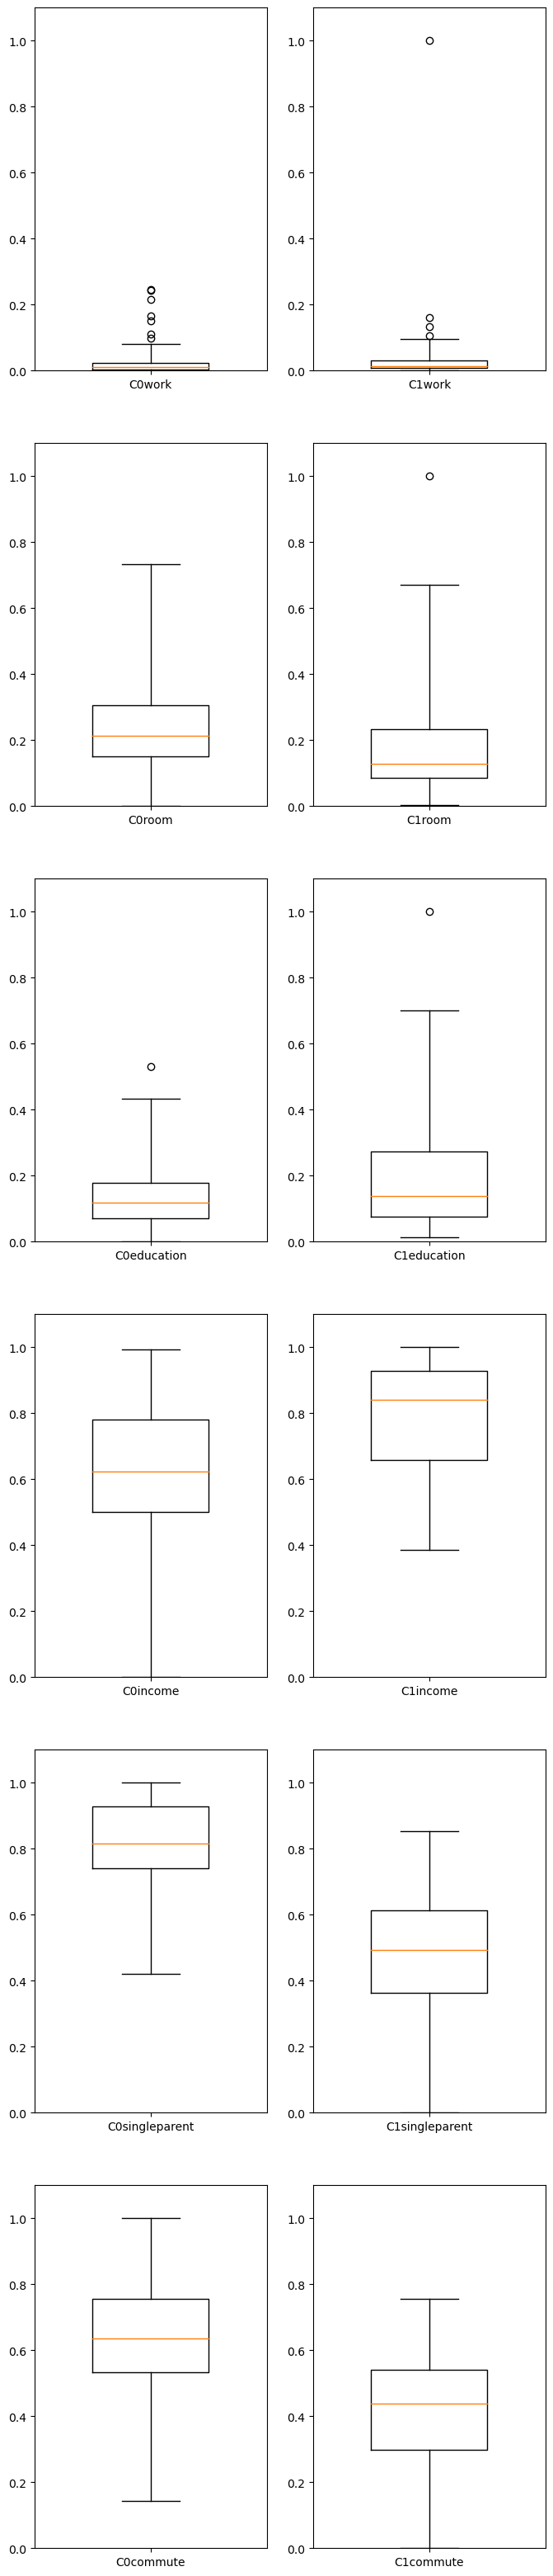

In [34]:
numplots=len(cols)
plt.figure(figsize=[10,numplots])
fig, axes = plt.subplots(numplots,2,figsize=[8,40])
for i in np.arange(0,numplots,1):
    axes[i,0].set_ylim((0,1.1))
    axes[i,1].set_ylim((0,1.1))
    axes[i,0].boxplot(C0[cols[i]],whis=3,labels=['C0'+cols[i]],widths=.5)
    axes[i,1].boxplot(C1[cols[i]],whis=3,labels=['C1'+cols[i]],widths=.5)
fig.savefig('6IndR1.png') #Save our figure to a file
plt.show()

In [35]:
df2.shape

(92, 34)

```{admonition} Exercise
Continue the same process one further step starting with the sub-cluster (C0 of C1) that exhibits greater hardship.
```